# EDA

Nuestro análisis consiste en identificar provincias, partidos , localidades con anchos de banda bajo con el fin de implementar un plan de acción para vender planes de enlaces satelitales de mayor capacidad. Nuestra empresa tiene un partnership con starlink para dicho caso, así como también busca invertir en la implementación de infraestructura para radioenlaces. Nuestros planes implican servicios desde 25Megas hasta 100Megas por acceso

Vamos a realizar la exploración de datos para tratar de identificar patrones, relaciones, tendencias, anomalias, etc, que nos ayuden a poder definir KPIs.


In [3]:
# importamos las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Carga del archivo XLSX. Este archivo tiene varias hojas. 
# Ya que tiene varias hojas. Vamos a leer el file como un diccionario de DataFrames
file = pd.read_excel("Data/Internet.xlsx", sheet_name=None)

In [5]:
# Hacemos un print de los nombres de todas las hojas.
print("Total sheets:", len(file), end="\n\n")
for num, key in enumerate(file.keys()):
    print(f"{num}: {key}")

Total sheets: 15

0: Acc_vel_loc_sinrangos
1: Velocidad_sin_Rangos
2: Accesos_tecnologia_localidad
3: Velocidad % por prov
4: Totales VMD
5: Totales Accesos Por Tecnología
6: Accesos Por Tecnología
7: Penetración-poblacion
8: Penetracion-hogares
9: Penetracion-totales
10: Totales Accesos por rango
11: Accesos por rangos
12: Dial-BAf
13: Totales Dial-BAf
14: Ingresos 


# Acc_vel_loc_sinrangos
El dataset muestra información detallada de accesos y velocidad actuales por provincia-partido-localidad.

Creamos los siguientes dataset:
- BW medio por partido
- Rangos de velocidad por partido
- Categorias de regiones

Se define el KPI:
- Rate de banda ancha

## ETL

In [214]:
# Revisión del primer dataset
data_df = file["Acc_vel_loc_sinrangos"].copy()
data_df.head()

,Provincia,Partido,Localidad,link INDEC,Velocidad (Mbps),Accesos
0,TIERRA DEL FUEGO,ANTARTIDA ARGENTINA,Base Orcadas,Sin Datos,1024.0,1.0
1,CABA,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,2000010,0.0,590.0
2,SAN LUIS,La Capital,San Luis,74056150,1000.0,10350.0
3,SAN LUIS,General Pedernera,Villa Mercedes,74035070,1000.0,4570.0
4,BUENOS AIRES,Lomas De Zamora,Banfield,6490010,1000.0,4513.0


In [215]:
data_df.info()
# Vemos valores nulos en Localidad. y Accesos.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18864 entries, 0 to 18863
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Provincia         18864 non-null  object 
 1   Partido           18864 non-null  object 
 2   Localidad         18863 non-null  object 
 3   link INDEC        18864 non-null  object 
 4   Velocidad (Mbps)  18864 non-null  float64
 5   Accesos           18857 non-null  float64
dtypes: float64(2), object(4)
memory usage: 884.4+ KB


In [216]:
data_df.describe()
# Observaciones:
# - Accesos: Vemos un valor negativo (?) Qué significado tiene esto.
# - Velocidad : 0 . Qué significado tiene esto? ¿Posiblenmente velocidades menores a 1Mbps?

,Velocidad (Mbps),Accesos
count,18864.000000,18857.000000
mean,66.866042,612.828499
std,178.987138,6283.359677
min,0.000000,-5582.000000
25%,3.000000,3.000000
50%,10.000000,26.000000
75%,30.000000,180.000000
max,1024.000000,576789.000000


In [217]:
#Planes de velocidad. Notamos que hay registros con planes de velocidad == 0.
np.sort(data_df["Velocidad (Mbps)"].unique())

array([0.0000e+00, 2.5600e-01, 5.0000e-01, 5.1200e-01, 7.5000e-01,
       1.0000e+00, 1.5000e+00, 2.0000e+00, 2.2000e+00, 2.5000e+00,
       3.0000e+00, 3.3000e+00, 3.5000e+00, 4.0000e+00, 4.5000e+00,
       5.0000e+00, 6.0000e+00, 6.4000e+00, 7.0000e+00, 7.5000e+00,
       8.0000e+00, 9.0000e+00, 1.0000e+01, 1.0100e+01, 1.0200e+01,
       1.1000e+01, 1.2000e+01, 1.2300e+01, 1.3000e+01, 1.4000e+01,
       1.5000e+01, 1.6000e+01, 1.7000e+01, 1.8000e+01, 2.0000e+01,
       2.0500e+01, 2.1000e+01, 2.2000e+01, 2.3000e+01, 2.4000e+01,
       2.5000e+01, 2.5100e+01, 2.5500e+01, 2.6000e+01, 2.7000e+01,
       3.0000e+01, 3.1000e+01, 3.2000e+01, 3.5000e+01, 3.6000e+01,
       4.0000e+01, 4.1000e+01, 4.5000e+01, 4.8000e+01, 4.9000e+01,
       5.0000e+01, 5.0100e+01, 5.0250e+01, 5.1000e+01, 5.5000e+01,
       5.9000e+01, 6.0000e+01, 6.1000e+01, 6.5000e+01, 6.6000e+01,
       7.0000e+01, 7.5000e+01, 8.0000e+01, 8.5000e+01, 9.0000e+01,
       9.5000e+01, 9.8000e+01, 1.0000e+02, 1.0010e+02, 1.0025e

### Revisión de Nulos

In [218]:
# En la columna Localidad, Vemos una localidad con valor NaN, y adicionalmente vemos una cantidad de accesos Negativa (-5582). Lo cual no parece tener sentido.
data_df[data_df["Localidad"].isnull()]

,Provincia,Partido,Localidad,link INDEC,Velocidad (Mbps),Accesos
1527,CABA,Ciudad Autónoma de Buenos Aires,NaN,Sin Datos,300.0,-5582.0


In [219]:
# Adicionalmente vemos otra entrada para la Velocidad de 300Mbps. Posiblemente esta entrada inicial es un error.
mask = (data_df["Provincia"]=='CABA') & (data_df["Velocidad (Mbps)"]==300)
data_df[mask]

,Provincia,Partido,Localidad,link INDEC,Velocidad (Mbps),Accesos
1527,CABA,Ciudad Autónoma de Buenos Aires,NaN,Sin Datos,300.0,-5582.0
13240,CABA,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,2000010,300.0,576789.0


In [220]:
# Dropeamos la entrada nula mencionada.
data_df.drop(index=1527, inplace=True)

In [221]:
# Nulos en columna accesos.
data_df[data_df["Accesos"].isnull()]
# Corresponden a velocidades posiblemente menores a 0megas, indicando posiblemente que no tienen accesos con estas velocidades.
# Podríamos eliminarlas o convertirlas en 0. 
# En este caso optaremos por eliminarlas.

,Provincia,Partido,Localidad,link INDEC,Velocidad (Mbps),Accesos
18018,SANTIAGO DEL ESTERO,Choya,Frías,86063040,0.0,NaN
18019,SANTA FE,Rosario,General Lagos,82084150,0.0,NaN
18020,SALTA,San Carlos,San Carlos,66154040,0.0,NaN
18021,SALTA,San Carlos,Animaná,66154020,0.0,NaN
18022,SALTA,Cafayate,Tolombón,66021020,0.0,NaN
18023,ENTRE RIOS,Tala,Rosario del Tala,30091100,0.0,NaN
18024,CORRIENTES,Ituzaingó,Colonia Liebig's,18084010,0.0,NaN


In [222]:
# Dropeamos los nulos.
data_df = data_df.dropna(subset=["Accesos"])
data_df.shape

(18856, 6)

In [223]:
# Lo siguiente que nos llama la atención son los accesos con valores negativos.
data_df[(data_df["Accesos"]<0)]

,Provincia,Partido,Localidad,link INDEC,Velocidad (Mbps),Accesos
18861,LA RIOJA,Otros,Otros,Sin Datos,0.0,-1.0
18862,CABA,Otros,Otros,Sin Datos,0.0,-590.0
18863,CORRIENTES,Otros,Otros,Sin Datos,0.0,-830.0


In [224]:
# Dado que parece ser errores de información, procedemos a eliminar estas entradas.
data_df.drop(index=[18861, 18862, 18863], inplace=True)
data_df.shape

(18853, 6)

In [225]:
# Ya no tenemos valores nulos.
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18853 entries, 0 to 18860
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Provincia         18853 non-null  object 
 1   Partido           18853 non-null  object 
 2   Localidad         18853 non-null  object 
 3   link INDEC        18853 non-null  object 
 4   Velocidad (Mbps)  18853 non-null  float64
 5   Accesos           18853 non-null  float64
dtypes: float64(2), object(4)
memory usage: 1.0+ MB


### Planes de velocidad con 0Mbps

In [226]:
mask = data_df["Velocidad (Mbps)"] == 0
data_df[mask].shape
#Tenemos un total de 836 entradas con plan == 0

(836, 6)

In [57]:
# Tenemos un total de 342789 accesos con velocidad = 0Mbps. Este es un número considerable. 
# Existen dos posibilidades a mi criterio:
#   - Son errores de entrada de datos.
#   - Son velocidades muy bajas como accesos DIAL UP.
data_df[mask]["Accesos"].sum()

np.float64(342789.0)

Tenemos un total de 342789 accesos con velocidad = 0Mbps. Este es un número considerable. 

Existen dos posibilidades a mi criterio:

  - Son errores de entrada de datos.
  - Son accesos con velocidades extramadamente bajas.

Optamos por no tocar estos datos y considerar la segunda opción, ya que se trata de un número considerable.

## BW Medio total por Región

In [227]:
# Creamos una copia del dataset.
test_df = data_df.copy()

# Calculamos producto parcial
test_df["Velocidad (Mbps) x Accesos"] = test_df["Velocidad (Mbps)"]*test_df["Accesos"]

# Agrupamos por Provincia y calculamos las sumas productos parcial y cantidad de accesos
summary_df = test_df.groupby(by="Provincia").agg(func={"Accesos": "sum",
                                                       "Velocidad (Mbps) x Accesos": "sum",})

#calculamos el promedio por region.
summary_df["Average Speed(Mbps)"]= summary_df["Velocidad (Mbps) x Accesos"]/summary_df["Accesos"]

# Ordenamos valores. y dropeamos la columna de productos parciales
summary_df = summary_df.sort_values(by="Average Speed(Mbps)", ascending=False).reset_index().drop(columns="Velocidad (Mbps) x Accesos")

#mostramos el df.
summary_df

,Provincia,Accesos,Average Speed(Mbps)
0,CABA,1469771.0,232.920150
1,SAN LUIS,157609.0,174.727460
2,BUENOS AIRES,4989380.0,153.449607
3,CORDOBA,1085774.0,115.565923
4,TUCUMAN,266914.0,108.785476
5,CHACO,147092.0,105.410026
6,CORRIENTES,157305.0,100.275717
7,SANTA FE,930973.0,99.349279
8,CATAMARCA,75074.0,97.314293
9,ENTRE RIOS,294311.0,96.183904


In [228]:
# Categorizamos las regiones de acuerdo a su BW medio.
summary_df["Categoria"] = summary_df.index//6 + 1

In [230]:
category_df = summary_df[["Provincia", "Categoria"]]
category_df

,Provincia,Categoria
0,CABA,1
1,SAN LUIS,1
2,BUENOS AIRES,1
3,CORDOBA,1
4,TUCUMAN,1
5,CHACO,1
6,CORRIENTES,2
7,SANTA FE,2
8,CATAMARCA,2
9,ENTRE RIOS,2


## BW medio total por partido
Vamos a calcular el BW medio por localidad, de esta manera sabremos que regiones tienen menor ancho de banda con respecto a la media.

In [131]:
# Agregamos una columna para poder hacer promedio ponderado posteriormente.
data_df["Velocidad x Accesos"] = data_df["Velocidad (Mbps)"] * data_df["Accesos"]

# Agrupamos y hacemos funciones de agregacion para la cantidad total de accesos y el producto hayado en el punto anterior.
velocidad_media_partido = data_df.groupby(by=["Provincia", "Partido"]).agg(
    Accesos = ("Accesos", "sum"),
    Suma_Velocidad_Accesos = ("Velocidad x Accesos", "sum"),
).reset_index()

# Calculamos la velocidad promedio por Localidad
velocidad_media_partido["Velocidad media(Mbps)"] = velocidad_media_partido["Suma_Velocidad_Accesos"] / velocidad_media_partido["Accesos"]
velocidad_media_partido.drop(columns="Suma_Velocidad_Accesos", inplace=True) #Dropeamos la columna ahora innecesaria

#Mostramos el dataset.
velocidad_media_partido

,Provincia,Partido,Accesos,Velocidad media(Mbps)
0,BUENOS AIRES,25 de Mayo,8753.0,28.761025
1,BUENOS AIRES,9 de Julio,16163.0,42.458810
2,BUENOS AIRES,AMBA,13.0,0.500000
3,BUENOS AIRES,Adolfo Alsina,5256.0,19.698440
4,BUENOS AIRES,Adolfo Gonzales Chaves,2964.0,10.654099
...,...,...,...,...
535,TUCUMAN,Simoca,392.0,3.048469
536,TUCUMAN,Tafí Viejo,23586.0,157.494955
537,TUCUMAN,Tafí del Valle,1248.0,12.671875
538,TUCUMAN,Trancas,611.0,15.217676


In [133]:
velocidad_media_partido.sort_values(by="Velocidad media(Mbps)").head(50)

,Provincia,Partido,Accesos,Velocidad media(Mbps)
533,TUCUMAN,Otros,134.0,0.000000
518,TIERRA DEL FUEGO,Otros,4.0,0.000000
479,SANTA FE,Otros,10553.0,0.000000
460,SAN LUIS,Otros,5963.0,0.000000
441,SAN JUAN,Otros,5617.0,0.000000
272,FORMOSA,Otros,36.0,0.000000
261,ENTRE RIOS,Otros,7251.0,0.000000
283,JUJUY,Otros,1374.0,0.000000
424,SALTA,Otros,185.0,0.000000
348,MENDOZA,Otros,1709.0,0.000000


Aquí encontramos una gran cantidad de PARTIDOS con anchos de banda cercanos a 0, es decir, que posiblemente usen tecnologias DIAL-UP.
Esto implica un posible nicho para la venta de enlaces de banda ancha.

## Agrupación de planes
Creamos una funcion para agrupar planes de BW de manera coherente para un mejor análisis.

In [ ]:

def asignacion_plan(speed):
    if speed > 30:
        return "30M+"
    elif speed > 20:
        return "20M-30M"
    elif speed > 10:
        return "10M-20M"
    elif speed > 6:
        return "6M-10M"
    elif speed > 1:
        return "1M-6M"
    elif speed > 0.512:
        return "512kbps-1M"
    else:
        return "Hasta 512kbps"

In [135]:
# Aplicamos la funcion
data_df["Rango_Velocidad"] = data_df["Velocidad (Mbps)"].apply(asignacion_plan)

In [137]:
# Agregamos la data por planes.
rangos_velocidad_partido = data_df.groupby(by=["Provincia", "Partido", "Rango_Velocidad"]).agg(
    Accesos = ("Accesos" , "sum")).reset_index()

rangos_velocidad_partido

,Provincia,Partido,Rango_Velocidad,Accesos
0,BUENOS AIRES,25 de Mayo,10M-20M,2570.0
1,BUENOS AIRES,25 de Mayo,1M-6M,1881.0
2,BUENOS AIRES,25 de Mayo,20M-30M,1674.0
3,BUENOS AIRES,25 de Mayo,30M+,1520.0
4,BUENOS AIRES,25 de Mayo,512kbps-1M,19.0
...,...,...,...,...
2927,TUCUMAN,Yerba Buena,20M-30M,29.0
2928,TUCUMAN,Yerba Buena,30M+,15921.0
2929,TUCUMAN,Yerba Buena,512kbps-1M,18.0
2930,TUCUMAN,Yerba Buena,6M-10M,384.0


## KPI: Rate de banda ancha
En este caso queremos identificar los partidos que tienen una gran cantidad de enlaces con BW menor a 6M.

Rate de banda ancha = # accesos de banda ancha / # accesos totales

In [173]:
#Creamos un dataframe pivot a partir del anteriormente calculado.
rangos_velocidad_partido_melted = rangos_velocidad_partido.pivot(index=["Provincia", "Partido"], columns=["Rango_Velocidad"], values='Accesos').reset_index()
# Reemplazmos los valores nulos por 0.
rangos_velocidad_partido_melted.fillna(0, inplace=True)
# Calculamos el total de enlaces.
rangos_velocidad_partido_melted["total"] = rangos_velocidad_partido_melted[['10M-20M', '1M-6M', '20M-30M', '30M+','512kbps-1M', '6M-10M', 'Hasta 512kbps']].apply(sum,axis=1)

# Calculamos el 'rate de banda ancha'. 
rangos_velocidad_partido_melted["rate_banda_ancha"]  = rangos_velocidad_partido_melted[['10M-20M',  '20M-30M', '30M+','6M-10M']].apply(sum,axis=1) / rangos_velocidad_partido_melted["total"] 

In [ ]:
# Visualizamos
rangos_velocidad_partido_melted

Rango_Velocidad,Provincia,Partido,10M-20M,1M-6M,20M-30M,30M+,512kbps-1M,6M-10M,Hasta 512kbps,total,rate_banda_ancha
0,BUENOS AIRES,25 de Mayo,2570.0,1881.0,1674.0,1520.0,19.0,1085.0,4.0,8753.0,0.782475
1,BUENOS AIRES,9 de Julio,2465.0,6578.0,373.0,3592.0,18.0,3137.0,0.0,16163.0,0.591907
2,BUENOS AIRES,AMBA,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,0.000000
3,BUENOS AIRES,Adolfo Alsina,2485.0,1437.0,1.0,1176.0,0.0,145.0,12.0,5256.0,0.724315
4,BUENOS AIRES,Adolfo Gonzales Chaves,1428.0,839.0,44.0,1.0,3.0,649.0,0.0,2964.0,0.715924
...,...,...,...,...,...,...,...,...,...,...,...
535,TUCUMAN,Simoca,0.0,392.0,0.0,0.0,0.0,0.0,0.0,392.0,0.000000
536,TUCUMAN,Tafí Viejo,625.0,880.0,19.0,20507.0,16.0,1538.0,1.0,23586.0,0.961969
537,TUCUMAN,Tafí del Valle,687.0,177.0,14.0,10.0,7.0,350.0,3.0,1248.0,0.850160
538,TUCUMAN,Trancas,448.0,65.0,19.0,24.0,1.0,54.0,0.0,611.0,0.891980


<Axes: xlabel='rate_banda_ancha'>

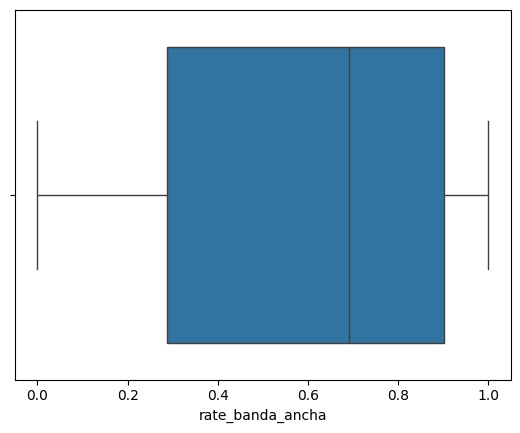

In [ ]:
# Graficamos.
sns.boxplot(data=rangos_velocidad_partido_melted, x="rate_banda_ancha")

In [179]:
# Obtenemos las provincias con menor rate.
rangos_velocidad_partido_melted[rangos_velocidad_partido_melted["rate_banda_ancha"]<0.3]

Rango_Velocidad,Provincia,Partido,10M-20M,1M-6M,20M-30M,30M+,512kbps-1M,6M-10M,Hasta 512kbps,total,rate_banda_ancha
2,BUENOS AIRES,AMBA,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,0.000000
47,BUENOS AIRES,General Belgrano,486.0,642.0,10.0,0.0,7.0,446.0,1919.0,3510.0,0.268376
51,BUENOS AIRES,General Las Heras,84.0,121.0,1.0,267.0,7.0,64.0,2225.0,2769.0,0.150235
54,BUENOS AIRES,General Pinto,8.0,1575.0,0.0,0.0,45.0,85.0,4.0,1717.0,0.054164
58,BUENOS AIRES,General Viamonte,196.0,4281.0,69.0,79.0,2.0,787.0,0.0,5414.0,0.208903
...,...,...,...,...,...,...,...,...,...,...,...
518,TIERRA DEL FUEGO,Otros,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.000000
521,TUCUMAN,Burruyacú,0.0,9.0,0.0,0.0,0.0,4.0,4.0,17.0,0.235294
526,TUCUMAN,Graneros,0.0,66.0,0.0,0.0,0.0,0.0,13.0,79.0,0.000000
533,TUCUMAN,Otros,0.0,0.0,0.0,0.0,0.0,0.0,134.0,134.0,0.000000


Conclusión del KPI:
- Tenemos un gran cantidad de regiones con un 'rate de banda ancha' bajo.
- Esto indica que podemos explorar estas zonas en búsqueda de posibles mercados.

# Velocidad sin Rangos
El dataset muestra información periódica sobre la cantidad de enlaces por cada plan de velocidad, sin agrupar rangos de velocidad. 

Creamos los siguientes dataset:
- Cantidad de enlaces por periodo.

Creamos el siguiente KPI:
- Tasa de incremento anual de enlaces

## ETL

In [ ]:
velocidad_sin_rangos = file["Velocidad_sin_Rangos"].copy()

In [193]:
velocidad_sin_rangos

,Año,Trimestre,Provincia,Velocidad,Accesos
0,2017,4,Buenos Aires,0.256,114182
1,2017,4,Buenos Aires,0.512,3865
2,2017,4,Buenos Aires,1.000,35185
3,2017,4,Buenos Aires,1.200,19861
4,2017,4,Buenos Aires,2.200,29124
...,...,...,...,...,...
18879,2024,2,TUCUMAN,200.000,1
18880,2024,2,TUCUMAN,300.000,45438
18881,2024,2,TUCUMAN,500.000,2471
18882,2024,2,TUCUMAN,600.000,2285


In [194]:
# Vistazo rápido
velocidad_sin_rangos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18884 entries, 0 to 18883
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Año        18884 non-null  int64  
 1   Trimestre  18884 non-null  int64  
 2   Provincia  18884 non-null  object 
 3   Velocidad  18874 non-null  float64
 4   Accesos    18884 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 737.8+ KB


In [195]:
# Valores nulos columna velocidad.
velocidad_sin_rangos[velocidad_sin_rangos["Velocidad"].isnull()]

,Año,Trimestre,Provincia,Velocidad,Accesos
6758,2020,4,Buenos Aires,NaN,4
7497,2021,1,Buenos Aires,NaN,4
8245,2021,2,Buenos Aires,NaN,4
9013,2021,3,Buenos Aires,NaN,4
12274,2022,3,Córdoba,NaN,1
12756,2022,3,Santa Fe,NaN,9
14826,2023,2,Córdoba,NaN,1
15312,2023,2,Santa Fe,NaN,9
17427,2024,1,Córdoba,NaN,1
17916,2024,1,Santa Fe,NaN,9


In [197]:
#remoción de valores. Se trata de valores que no afectarán las métricas
velocidad_sin_rangos.dropna(subset=["Velocidad"], inplace=True)

In [198]:
# Detectamos valores NO normalizados en la columna provincia
np.sort(velocidad_sin_rangos["Provincia"].unique())

array(['BUENOS AIRES', 'Buenos Aires', 'CABA', 'CATAMARCA', 'CHACO',
       'CHUBUT', 'CORDOBA', 'CORRIENTES', 'Capital Federal', 'Catamarca',
       'Chaco', 'Chubut', 'Corrientes', 'Córdoba', 'ENTRE RIOS',
       'Entre Ríos', 'FORMOSA', 'Formosa', 'JUJUY', 'Jujuy', 'LA PAMPA',
       'LA RIOJA', 'La Pampa', 'La Rioja', 'MENDOZA', 'MISIONES',
       'Mendoza', 'Misiones', 'NEUQUEN', 'Neuquén', 'RIO NEGRO',
       'Río Negro', 'SALTA', 'SAN JUAN', 'SAN LUIS', 'SANTA CRUZ',
       'SANTA FE', 'SANTIAGO DEL ESTERO', 'Salta', 'San Juan', 'San Luis',
       'Santa Cruz', 'Santa Fe', 'Santiago Del Estero',
       'TIERRA DEL FUEGO', 'TUCUMAN', 'Tierra Del Fuego', 'Tucumán'],
      dtype=object)

In [199]:
# Normalizamos.

#Primero aplicamos caps a todos los valores
velocidad_sin_rangos["Provincia"] = velocidad_sin_rangos["Provincia"].apply(str.upper)

#Removemos los acentos.
replace_dict = {"Á" : "A", "É" : "E", "Í" : "I", "Ó" : "O", "Ú": "U"}
for key, value in replace_dict.items():
    velocidad_sin_rangos["Provincia"] = velocidad_sin_rangos["Provincia"].apply(str.replace, args=(key, value))

# Ultimamente observamos que CABA y CAPITAL FEDERAL representan la misma provincia
velocidad_sin_rangos["Provincia"] = velocidad_sin_rangos["Provincia"].apply(str.replace, args=("CAPITAL FEDERAL", "CABA"))

In [200]:
# Visualizamos:
np.sort(velocidad_sin_rangos["Provincia"].unique())

array(['BUENOS AIRES', 'CABA', 'CATAMARCA', 'CHACO', 'CHUBUT', 'CORDOBA',
       'CORRIENTES', 'ENTRE RIOS', 'FORMOSA', 'JUJUY', 'LA PAMPA',
       'LA RIOJA', 'MENDOZA', 'MISIONES', 'NEUQUEN', 'RIO NEGRO', 'SALTA',
       'SAN JUAN', 'SAN LUIS', 'SANTA CRUZ', 'SANTA FE',
       'SANTIAGO DEL ESTERO', 'TIERRA DEL FUEGO', 'TUCUMAN'], dtype=object)

## Cantidad de enlaces por periodo

In [207]:
# Creamos la columna periodo para poder agrupar.
velocidad_sin_rangos["Periodo"] = velocidad_sin_rangos["Año"].astype(str) + "-Q" + velocidad_sin_rangos["Trimestre"].astype(str)

# Creamos la columna velocidad * accesos
velocidad_sin_rangos["Velocidad * Accesos"] = velocidad_sin_rangos["Velocidad"] * velocidad_sin_rangos["Accesos"]

# Agregamos
enlaces_por_periodo_region = velocidad_sin_rangos.groupby(by=["Provincia", "Periodo"]).agg(
    Accesos = ("Accesos", "sum"),
    Sum_velocidad_x_accesos = ("Velocidad * Accesos", 'sum')
).reset_index()

In [210]:
# Calculamos también el BW Medio por periodo
enlaces_por_periodo_region["BW Medio"] = enlaces_por_periodo_region["Sum_velocidad_x_accesos"] / enlaces_por_periodo_region["Accesos"]

# Visualizamos
enlaces_por_periodo_region

,Provincia,Periodo,Accesos,Sum_velocidad_x_accesos,BW Medio
0,BUENOS AIRES,2017-Q4,3188332,4.114651e+07,12.905339
1,BUENOS AIRES,2018-Q1,3471700,4.945306e+07,14.244624
2,BUENOS AIRES,2018-Q2,3500699,5.110328e+07,14.598022
3,BUENOS AIRES,2018-Q3,3610277,6.009036e+07,16.644253
4,BUENOS AIRES,2018-Q4,3636606,6.280051e+07,17.268989
...,...,...,...,...,...
643,TUCUMAN,2023-Q2,264595,2.827113e+07,106.846809
644,TUCUMAN,2023-Q3,266557,2.722369e+07,102.130828
645,TUCUMAN,2023-Q4,266335,2.796225e+07,104.989031
646,TUCUMAN,2024-Q1,264595,2.827113e+07,106.846809


In [211]:
enlaces_por_periodo_region.describe()

,Accesos,Sum_velocidad_x_accesos,BW Medio
count,6.480000e+02,6.480000e+02,648.000000
mean,4.115802e+05,2.776213e+07,37.671765
std,8.686412e+05,9.442343e+07,40.745203
min,1.490000e+04,7.845269e+04,3.669100
25%,8.620400e+04,1.087521e+06,10.819029
50%,1.294935e+05,3.129961e+06,20.095499
75%,2.197040e+05,1.364971e+07,47.284000
max,5.044557e+06,8.140523e+08,243.466719


## KPI: Tasa de incremento anual de enlaces
Queremos medir como va evolucionando la cantidad de enlaces de manera anual para cada provincia.
De esta manera podemos identificar Provincias con bajos indices de evolución que necesiten intervención o mayor oferta.

In [234]:
# Removemos columnas innecesarias
variacion_anual_enlaces = enlaces_por_periodo_region.drop(columns=["Sum_velocidad_x_accesos", "BW Medio"])

In [246]:
# Capturamos el trimestre y luego tomaremos solo valores iguales al Q1 para tener periodos anuales.
variacion_anual_enlaces["Trimestre"] = variacion_anual_enlaces["Periodo"].apply(lambda x: x[6:]).astype(int)
variacion_anual_enlaces = variacion_anual_enlaces[variacion_anual_enlaces["Trimestre"] ==1]
variacion_anual_enlaces

,Provincia,Periodo,Accesos,Trimestre
1,BUENOS AIRES,2018-Q1,3471700,1
5,BUENOS AIRES,2019-Q1,3732709,1
9,BUENOS AIRES,2020-Q1,3718747,1
13,BUENOS AIRES,2021-Q1,4059998,1
17,BUENOS AIRES,2022-Q1,4555424,1
...,...,...,...,...
630,TUCUMAN,2020-Q1,200449,1
634,TUCUMAN,2021-Q1,231912,1
638,TUCUMAN,2022-Q1,245584,1
642,TUCUMAN,2023-Q1,261100,1


In [249]:
variacion_anual_enlaces["Tasa incremental anual"] = variacion_anual_enlaces.groupby(by=["Provincia"])["Accesos"].pct_change()
variacion_anual_enlaces

C:\Users\Une\AppData\Local\Temp\ipykernel_32516\3202296925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variacion_anual_enlaces["Tasa incremental anual"] = variacion_anual_enlaces.groupby(by=["Provincia"])["Accesos"].pct_change()


,Provincia,Periodo,Accesos,Trimestre,Tasa incremental anual
1,BUENOS AIRES,2018-Q1,3471700,1,NaN
5,BUENOS AIRES,2019-Q1,3732709,1,0.075182
9,BUENOS AIRES,2020-Q1,3718747,1,-0.003740
13,BUENOS AIRES,2021-Q1,4059998,1,0.091765
17,BUENOS AIRES,2022-Q1,4555424,1,0.122026
...,...,...,...,...,...
630,TUCUMAN,2020-Q1,200449,1,0.163933
634,TUCUMAN,2021-Q1,231912,1,0.156963
638,TUCUMAN,2022-Q1,245584,1,0.058953
642,TUCUMAN,2023-Q1,261100,1,0.063180


<Axes: xlabel='Periodo', ylabel='Tasa incremental anual'>

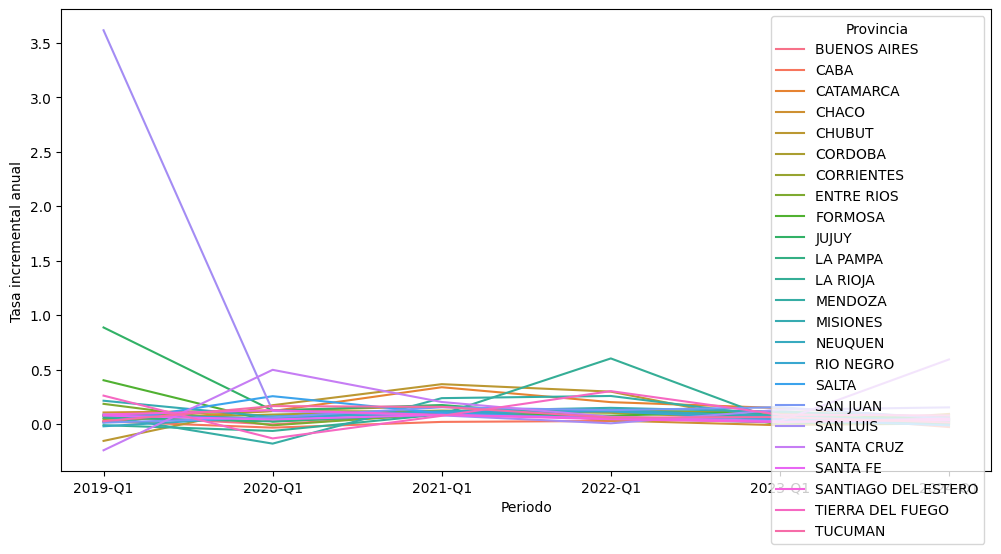

In [255]:
plt.figure(figsize=(12,6))
sns.lineplot(data=variacion_anual_enlaces, x="Periodo", y= "Tasa incremental anual" , hue="Provincia")

In [252]:
# Posteriormente podemos visualizar la media por region de los ultimos años.
variacion_anual_media_enlaces = variacion_anual_enlaces.dropna().groupby("Provincia").agg(Tasa_incremental_media = ("Tasa incremental anual", "mean")).sort_values(by="Tasa_incremental_media").reset_index()
variacion_anual_media_enlaces

,Provincia,Tasa_incremental_media
0,CABA,0.016781
1,SANTA FE,0.051632
2,NEUQUEN,0.059590
3,BUENOS AIRES,0.064984
4,SANTIAGO DEL ESTERO,0.067659
5,LA PAMPA,0.068454
6,CORDOBA,0.072300
7,ENTRE RIOS,0.072406
8,RIO NEGRO,0.074763
9,SALTA,0.074909


<Axes: xlabel='Provincia', ylabel='Tasa_incremental_media'>

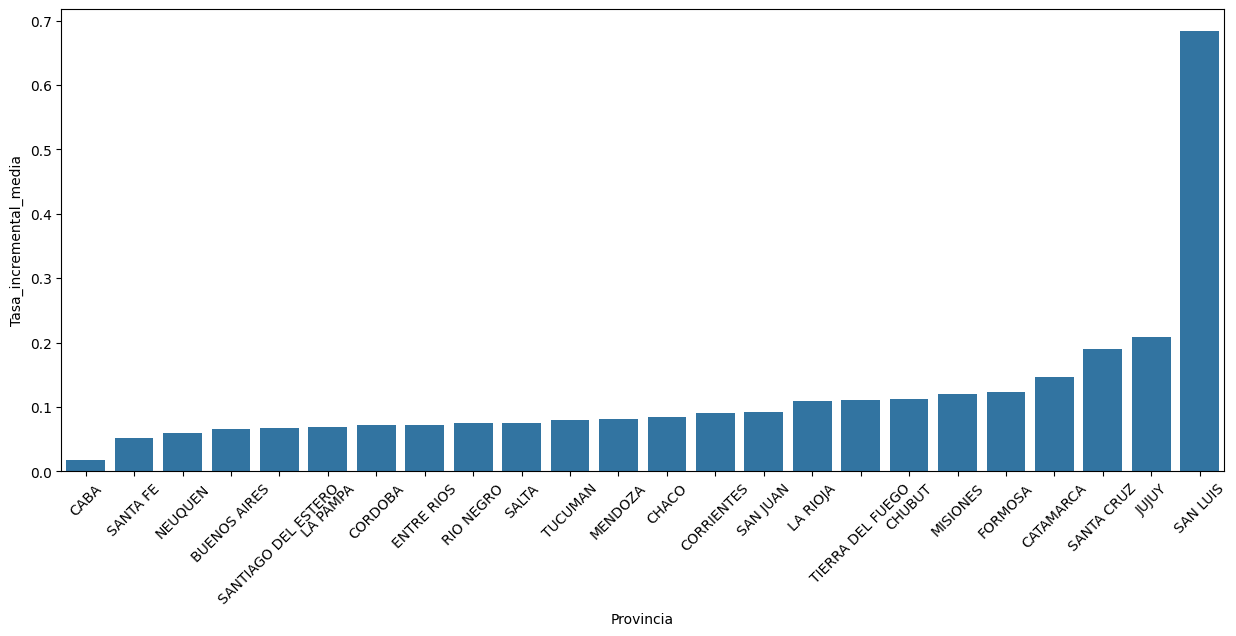

In [261]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=45)
sns.barplot(data=variacion_anual_media_enlaces, x="Provincia", y="Tasa_incremental_media")

De esta manera podemos también identificar zonas que han tenido bajo crecimiento medio en los últimos años. Vamos a hacer un cruce con nuestro dataset de categorias, para visualizar rapidamente las zonas de menor nivel y con menos crecimiento.

In [264]:
pd.merge(variacion_anual_media_enlaces, category_df, on="Provincia").sort_values(by=["Categoria", "Tasa_incremental_media"])

,Provincia,Tasa_incremental_media,Categoria
0,CABA,0.016781,1
3,BUENOS AIRES,0.064984,1
6,CORDOBA,0.072300,1
10,TUCUMAN,0.080269,1
12,CHACO,0.083867,1
23,SAN LUIS,0.683718,1
1,SANTA FE,0.051632,2
2,NEUQUEN,0.059590,2
7,ENTRE RIOS,0.072406,2
13,CORRIENTES,0.090273,2


Conclusiones:

- Identificamos zonas como SANTIAGO DEL ESTERO, LA PAMPA, RIO NEGRO, SALTA como posibles puntos de enfoque

# Velocidad % por prov
Un dataset que indica la velocidad media por periodo por provincia
Se observa periodos específicos de incremento de BW medio por provincia, a excepción de ciertos lugares.

In [266]:
# Cargamos el dataset yu visualizamos
mean_speed_df = file["Velocidad % por prov"].copy()
mean_speed_df

,Año,Trimestre,Provincia,Mbps (Media de bajada)
0,2024,2,Buenos Aires,157.410000
1,2024,2,Capital Federal,233.010000
2,2024,2,Catamarca,97.380000
3,2024,2,Chaco,107.760000
4,2024,2,Chubut,21.670000
...,...,...,...,...
1003,2014,1,Santa Cruz,3.315991
1004,2014,1,Santa Fe,3.147407
1005,2014,1,Santiago Del Estero,2.949472
1006,2014,1,Tierra Del Fuego,3.446888


In [267]:
# sin nulos
mean_speed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Año                     1008 non-null   int64  
 1   Trimestre               1008 non-null   int64  
 2   Provincia               1008 non-null   object 
 3   Mbps (Media de bajada)  1008 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 31.6+ KB


In [268]:
# sin valores fuera de lo normal
mean_speed_df.describe()

,Año,Trimestre,Mbps (Media de bajada)
count,1008.000000,1008.000000,1008.000000
mean,2018.761905,2.452381,24.720245
std,3.039439,1.117574,33.660764
min,2014.000000,1.000000,2.573729
25%,2016.000000,1.000000,4.866698
50%,2019.000000,2.000000,10.089315
75%,2021.000000,3.000000,29.875292
max,2024.000000,4.000000,234.440000


In [269]:
# Los nombres estan en minúsculas. Figuran las 24 provincias. CABA figura como 'Capital Federal'
mean_speed_df["Provincia"].unique()

array(['Buenos Aires', 'Capital Federal', 'Catamarca', 'Chaco', 'Chubut',
       'Córdoba', 'Corrientes', 'Entre Ríos', 'Formosa', 'Jujuy',
       'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén',
       'Río Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz',
       'Santa Fe', 'Santiago Del Estero', 'Tierra Del Fuego', 'Tucumán'],
      dtype=object)

In [270]:
# Convertimos los valores a Mayusculas, sin tilde, y cambiamos Capital Federal por CABA.

mean_speed_df["Provincia"] = mean_speed_df["Provincia"].apply(str.upper)
mean_speed_df["Provincia"] = mean_speed_df["Provincia"].replace("CAPITAL FEDERAL", "CABA")

replace_dict = {"Á" : "A", "É" : "E", "Í" : "I", "Ó" : "O", "Ú": "U"}
for key, value in replace_dict.items():
    mean_speed_df["Provincia"] = mean_speed_df["Provincia"].apply(str.replace, args=(key, value))

mean_speed_df["Provincia"].unique()

array(['BUENOS AIRES', 'CABA', 'CATAMARCA', 'CHACO', 'CHUBUT', 'CORDOBA',
       'CORRIENTES', 'ENTRE RIOS', 'FORMOSA', 'JUJUY', 'LA PAMPA',
       'LA RIOJA', 'MENDOZA', 'MISIONES', 'NEUQUEN', 'RIO NEGRO', 'SALTA',
       'SAN JUAN', 'SAN LUIS', 'SANTA CRUZ', 'SANTA FE',
       'SANTIAGO DEL ESTERO', 'TIERRA DEL FUEGO', 'TUCUMAN'], dtype=object)

In [271]:
# Agregamos las columnas Categoria y Periodo.
mean_speed_df = pd.merge(mean_speed_df, category_df, on="Provincia")

In [272]:
mean_speed_df["Periodo"] = mean_speed_df["Año"].astype(str) + "-Q" + mean_speed_df["Trimestre"].astype(str)
mean_speed_df

,Año,Trimestre,Provincia,Mbps (Media de bajada),Categoria,Periodo
0,2024,2,BUENOS AIRES,157.410000,1,2024-Q2
1,2024,2,CABA,233.010000,1,2024-Q2
2,2024,2,CATAMARCA,97.380000,2,2024-Q2
3,2024,2,CHACO,107.760000,1,2024-Q2
4,2024,2,CHUBUT,21.670000,4,2024-Q2
...,...,...,...,...,...,...
1003,2014,1,SANTA CRUZ,3.315991,4,2014-Q1
1004,2014,1,SANTA FE,3.147407,2,2014-Q1
1005,2014,1,SANTIAGO DEL ESTERO,2.949472,4,2014-Q1
1006,2014,1,TIERRA DEL FUEGO,3.446888,4,2014-Q1


<Axes: xlabel='Periodo', ylabel='Mbps (Media de bajada)'>

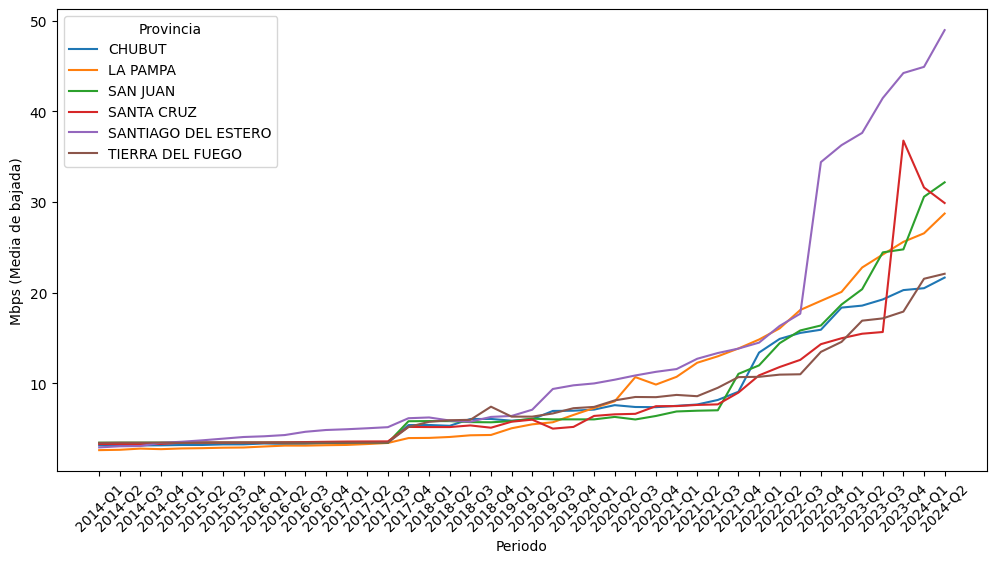

In [284]:
# Vamos a graficar las velocidades medias por periodo por categoria.
# filtro
categoria = 4


mask = mean_speed_df["Categoria"] == categoria
graph_data = mean_speed_df[mask].sort_values(by=["Año", "Trimestre"])

plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
sns.lineplot(data=graph_data, x="Periodo", y="Mbps (Media de bajada)", hue="Provincia")

Observaciones: 

En general se observa un incremento explosivo en el BW medio para las regiones 1 2 3 , sin embargo, se observa un retraso para para 5 de las regiones de la categoria 4. Lo que nuevamente indica una falta de inversión en estas localidades.

# Accesos Tecnologia por Localidad
Se trata de un dataset que muestra la cantidad de accesos por tecnología en cada localidad.

Útil para identificar qué tecnologías predominan mayormente en qué regiones y partidos.

Se define el KPI: 
 - Ratio de adopción de tecnologia.

## ETL

In [285]:
# Cargamos datos
tecnologias_df = file["Accesos_tecnologia_localidad"].copy()

In [286]:
# Observamos nulos en la columna accesos
tecnologias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7753 entries, 0 to 7752
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Provincia   7753 non-null   object 
 1   Partido     7753 non-null   object 
 2   Localidad   7753 non-null   object 
 3   Tecnologia  7753 non-null   object 
 4   Link Indec  7753 non-null   object 
 5   Accesos     7747 non-null   float64
dtypes: float64(1), object(5)
memory usage: 363.6+ KB


In [287]:
# Observamos los datos Nulos.
tecnologias_df[tecnologias_df["Accesos"].isnull()]

,Provincia,Partido,Localidad,Tecnologia,Link Indec,Accesos
3755,CORRIENTES,Ituzaingó,Colonia Liebig's,Otros,18084010,NaN
4101,ENTRE RIOS,Tala,Rosario del Tala,Otros,30091100,NaN
5744,SALTA,Cafayate,Tolombón,Otros,66021020,NaN
6005,SALTA,San Carlos,Animaná,Otros,66154020,NaN
6010,SALTA,San Carlos,San Carlos,Otros,66154040,NaN
7372,SANTIAGO DEL ESTERO,Choya,Frías,Otros,86063040,NaN


In [288]:
# Reemplazamos por 0
tecnologias_df["Accesos"] = tecnologias_df["Accesos"].fillna(0)

In [289]:
# Observamos la columna Provincias, con valores correctos. 
tecnologias_df["Provincia"].unique()

array(['BUENOS AIRES', 'CABA', 'CATAMARCA', 'CHACO', 'CHUBUT', 'CORDOBA',
       'CORRIENTES', 'ENTRE RIOS', 'FORMOSA', 'JUJUY', 'LA PAMPA',
       'LA RIOJA', 'MENDOZA', 'MISIONES', 'NEUQUEN', 'RIO NEGRO', 'SALTA',
       'SAN JUAN', 'SAN LUIS', 'SANTA CRUZ', 'SANTA FE',
       'SANTIAGO DEL ESTERO', 'TIERRA DEL FUEGO', 'TUCUMAN'], dtype=object)

In [290]:
#Observamos falta de normalización en la columna Tecnologia
tecnologias_df["Tecnologia"].unique()

array(['ADSL', 'CABLEMODEM', 'FIBRA OPTICA', 'SATELITAL', 'WIRELESS',
       'Otros', 'DIAL UP', 'OTROS', 'WIMAX', 'Cablemodem'], dtype=object)

In [291]:
#normalizamos.
tecnologias_df["Tecnologia"] = tecnologias_df["Tecnologia"].str.upper()
tecnologias_df["Tecnologia"].unique()

array(['ADSL', 'CABLEMODEM', 'FIBRA OPTICA', 'SATELITAL', 'WIRELESS',
       'OTROS', 'DIAL UP', 'WIMAX'], dtype=object)

In [ ]:
# Vamos a normalizar las tecnologias SATELITAL y WIMAX como WIRELES. Así mismo, DIAL-UP con OTROS. Esto con el fin de tener concordancia con los demás datasets.
tecnologias_df["Tecnologia"].replace("WIMAX", "WIRELESS", inplace=True)
tecnologias_df["Tecnologia"].replace("SATELITAL", "WIRELESS", inplace=True)
tecnologias_df["Tecnologia"].replace("DIAL UP", "OTROS", inplace=True)

In [296]:
tecnologias_df["Tecnologia"].unique()

array(['ADSL', 'CABLEMODEM', 'FIBRA OPTICA', 'WIRELESS', 'OTROS'],
      dtype=object)

In [299]:
# Vamos a hacer una agregación de de tecnologías por Provincia y Partido.
tecnologias_sum_df = tecnologias_df.groupby(by=["Provincia", "Partido", "Tecnologia"]).agg(Accesos=("Accesos", "sum")).reset_index()
tecnologias_sum_df

,Provincia,Partido,Tecnologia,Accesos
0,BUENOS AIRES,25 de Mayo,ADSL,1165.0
1,BUENOS AIRES,25 de Mayo,CABLEMODEM,5382.0
2,BUENOS AIRES,25 de Mayo,FIBRA OPTICA,523.0
3,BUENOS AIRES,25 de Mayo,OTROS,47.0
4,BUENOS AIRES,25 de Mayo,WIRELESS,1849.0
...,...,...,...,...
1994,TUCUMAN,Yerba Buena,ADSL,649.0
1995,TUCUMAN,Yerba Buena,CABLEMODEM,76.0
1996,TUCUMAN,Yerba Buena,FIBRA OPTICA,17950.0
1997,TUCUMAN,Yerba Buena,OTROS,34.0


In [300]:
# Hacemos un reshape
accesos_tecnologia_provincia = tecnologias_sum_df.pivot(index=["Provincia", "Partido"], columns="Tecnologia", values="Accesos").reset_index().fillna(0)
# Agregamos la columna totales:
accesos_tecnologia_provincia["Total"] = accesos_tecnologia_provincia.iloc[:, 2:].sum(axis=1)
# Mostramos el dataset
accesos_tecnologia_provincia

Tecnologia,Provincia,Partido,ADSL,CABLEMODEM,FIBRA OPTICA,OTROS,WIRELESS,Total
0,BUENOS AIRES,25 de Mayo,1165.0,5382.0,523.0,47.0,1849.0,8966.0
1,BUENOS AIRES,9 de Julio,4965.0,3463.0,6358.0,142.0,1546.0,16474.0
2,BUENOS AIRES,AMBA,0.0,0.0,0.0,0.0,13.0,13.0
3,BUENOS AIRES,Adolfo Alsina,766.0,0.0,3384.0,2.0,1089.0,5241.0
4,BUENOS AIRES,Adolfo Gonzales Chaves,464.0,0.0,1597.0,8.0,807.0,2876.0
...,...,...,...,...,...,...,...,...
525,TUCUMAN,Simoca,0.0,0.0,0.0,0.0,392.0,392.0
526,TUCUMAN,Tafí Viejo,1933.0,593.0,21047.0,11.0,11.0,23595.0
527,TUCUMAN,Tafí del Valle,135.0,0.0,474.0,1.0,639.0,1249.0
528,TUCUMAN,Trancas,83.0,0.0,0.0,33.0,495.0,611.0


## KPI: Ratio de adopción de tecnologia
Con la información obtenida podemos calcular el Ratio de adopción de tecnologia para cada tecnologia en cada region:
Lo definiremos como:

Ratio de Adopcion (Tecnologia) = Total Accesos (Tecnologia) / Total Accesos (Region)

La idea es explicar inicialmente que tanto predomina cierta tecnologia en cada región.

In [301]:
# Calculamos el kpi
ratio_accesos_tecnologia = accesos_tecnologia_provincia.iloc[:, 2:].apply(lambda row: row / row["Total"], axis=1)
ratio_accesos_tecnologia = pd.merge(accesos_tecnologia_provincia[["Provincia", "Partido"]], ratio_accesos_tecnologia, left_index=True, right_index=True)
ratio_accesos_tecnologia.drop(columns="Total", inplace=True)
ratio_accesos_tecnologia

Tecnologia,Provincia,Partido,ADSL,CABLEMODEM,FIBRA OPTICA,OTROS,WIRELESS
0,BUENOS AIRES,25 de Mayo,0.129935,0.600268,0.058331,0.005242,0.206224
1,BUENOS AIRES,9 de Julio,0.301384,0.210210,0.385941,0.008620,0.093845
2,BUENOS AIRES,AMBA,0.000000,0.000000,0.000000,0.000000,1.000000
3,BUENOS AIRES,Adolfo Alsina,0.146155,0.000000,0.645678,0.000382,0.207785
4,BUENOS AIRES,Adolfo Gonzales Chaves,0.161335,0.000000,0.555285,0.002782,0.280598
...,...,...,...,...,...,...,...
525,TUCUMAN,Simoca,0.000000,0.000000,0.000000,0.000000,1.000000
526,TUCUMAN,Tafí Viejo,0.081924,0.025132,0.892011,0.000466,0.000466
527,TUCUMAN,Tafí del Valle,0.108086,0.000000,0.379504,0.000801,0.511609
528,TUCUMAN,Trancas,0.135843,0.000000,0.000000,0.054010,0.810147


Para nuestro análisis, nos conviene identificar las regiones con baja penetración de fibra y cablemodem.
Uniremos ambos en una columna y observamores los valores mas bajos. 

In [307]:
# Creamos una nueva columna
ratio_accesos_tecnologia["CABLEMODEM+FIBRA"] = ratio_accesos_tecnologia["CABLEMODEM"] + ratio_accesos_tecnologia["FIBRA OPTICA"]
ratio_accesos_tecnologia.sort_values(by=["CABLEMODEM+FIBRA"], ascending=True).head(50)

Tecnologia,Provincia,Partido,ADSL,CABLEMODEM,FIBRA OPTICA,OTROS,WIRELESS,CABLEMODEM+FIBRA
525,TUCUMAN,Simoca,0.000000,0.0,0.0,0.000000,1.000000,0.0
524,TUCUMAN,Río Chico,0.920204,0.0,0.0,0.000000,0.079796,0.0
494,SANTIAGO DEL ESTERO,Loreto,0.000000,0.0,0.0,0.000000,1.000000,0.0
491,SANTIAGO DEL ESTERO,Guasayán,0.009662,0.0,0.0,0.966184,0.024155,0.0
269,FORMOSA,Matacos,0.413793,0.0,0.0,0.000000,0.586207,0.0
268,FORMOSA,Laishi,0.004320,0.0,0.0,0.000000,0.995680,0.0
266,FORMOSA,Bermejo,0.000000,0.0,0.0,0.000000,1.000000,0.0
259,ENTRE RIOS,Otros,0.000000,0.0,0.0,1.000000,0.000000,0.0
452,SAN LUIS,Otros,0.000000,0.0,0.0,1.000000,0.000000,0.0
238,CORRIENTES,Otros,0.000000,0.0,0.0,1.000000,0.000000,0.0


<Axes: ylabel='CABLEMODEM+FIBRA'>

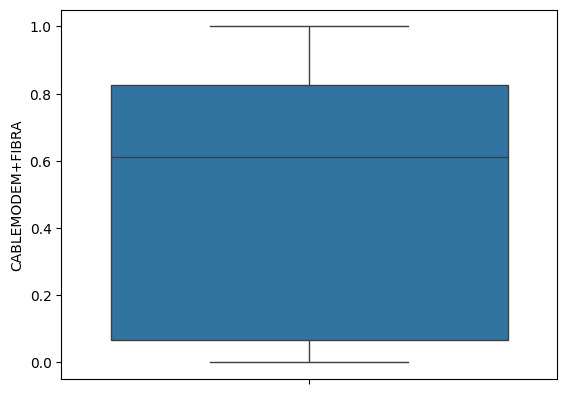

In [ ]:
# Si observamos de manera general. 
# Vemos que hay una aceptacion moderada de la fibra y el cable modem.
sns.boxplot(data=ratio_accesos_tecnologia, y="CABLEMODEM+FIBRA")

In [1]:
# Pero examinando provincia por provincia
plt.figure(figsize=(18,6))
sns.violinplot(data=ratio_accesos_tecnologia, y="CABLEMODEM+FIBRA", hue="Provincia")

NameError: name 'plt' is not defined

Observaciones:

- Se observa que en general, las tecnologías predominantes son: Fibra optica, CABLEMODEM
- Las regiones con menor BW Medio tienen mayor adopcion de ADSL, DIAL UP, SATELITAL y WIRELESS que otras regiones.
- Existen gran cantidad de Partidos con una penetración de fibra casi nula, lo que los hace grandes candidatos para nuestra tecnologia wireless.

# Totales VMD

Se trata de un dataset simple con la evolución de la velocidad media de bajada total de los ultimos 10 años.
Talvez se pueda usar posteriormente para un resumen. 

In [71]:
total_vmd = file["Totales VMD"]
total_vmd["Periodo"] = total_vmd["Año"].astype(str) + "-Q" + total_vmd["Trimestre"].astype(str)
total_vmd.drop(columns="Trimestre.1", inplace=True)
total_vmd

,Año,Trimestre,Mbps (Media de bajada),Periodo
0,2024,2,139.250000,2024-Q2
1,2024,1,139.150000,2024-Q1
2,2023,4,139.040000,2023-Q4
3,2023,3,129.670000,2023-Q3
4,2023,2,123.950000,2023-Q2
5,2023,1,110.500000,2023-Q1
6,2022,4,106.560000,2022-Q4
7,2022,3,62.460000,2022-Q3
8,2022,2,58.440000,2022-Q2
9,2022,1,55.110000,2022-Q1


# Totales Accesos Por Tecnología
Representa la evolución total de las tecnologias a nivel nacional

Definimos un KPI: TASA CRECIMIENTO ANUAL de TECNOLOGIA

In [316]:
# Cargamos el archivo.
totales_accesos_por_tecnologia = file["Totales Accesos Por Tecnología"].copy()

In [317]:
# Modificamos la columna periodo para mejor entendimiento
totales_accesos_por_tecnologia["Periodo"] = totales_accesos_por_tecnologia["Año"].astype(str) + "-Q" + totales_accesos_por_tecnologia["Trimestre"].astype(str)
totales_accesos_por_tecnologia = totales_accesos_por_tecnologia.sort_values(by=["Año", "Trimestre"])
totales_accesos_por_tecnologia

,Año,Trimestre,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total,Periodo
41,2014,1,3697066,2407330,150323,70749,72930,6398398,2014-Q1
40,2014,2,3708882,2461670,149363,72405,72148,6464468,2014-Q2
39,2014,3,3714764,2569868,155494,85096,70049,6595271,2014-Q3
38,2014,4,3764038,2536219,149682,76984,71573,6598496,2014-Q4
37,2015,1,3756153,2668248,168188,79098,66045,6737732,2015-Q1
36,2015,2,3767821,2756294,150839,82077,59157,6816188,2015-Q2
35,2015,3,3788696,2840203,162663,84530,58976,6935068,2015-Q3
34,2015,4,3803024,2898226,139187,85726,58668,6984831,2015-Q4
33,2016,1,3792493,2806359,164371,85370,58763,6907356,2016-Q1
32,2016,2,3782085,3035272,167788,85452,59482,7130079,2016-Q2


In [318]:
# Vamos a usar el método MELT para poder graficar
totales_accesos_por_tecnologia_melted = totales_accesos_por_tecnologia.melt(['Año', 'Trimestre','Periodo', 'Total']).sort_values(by=["Año", "Trimestre", "variable"])
totales_accesos_por_tecnologia_melted

,Año,Trimestre,Periodo,Total,variable,value
0,2014,1,2014-Q1,6398398,ADSL,3697066
42,2014,1,2014-Q1,6398398,Cablemodem,2407330
84,2014,1,2014-Q1,6398398,Fibra óptica,150323
168,2014,1,2014-Q1,6398398,Otros,72930
126,2014,1,2014-Q1,6398398,Wireless,70749
...,...,...,...,...,...,...
41,2024,2,2024-Q2,11556107,ADSL,733491
83,2024,2,2024-Q2,11556107,Cablemodem,5867504
125,2024,2,2024-Q2,11556107,Fibra óptica,4169958
209,2024,2,2024-Q2,11556107,Otros,191957


<Axes: xlabel='Periodo', ylabel='value'>

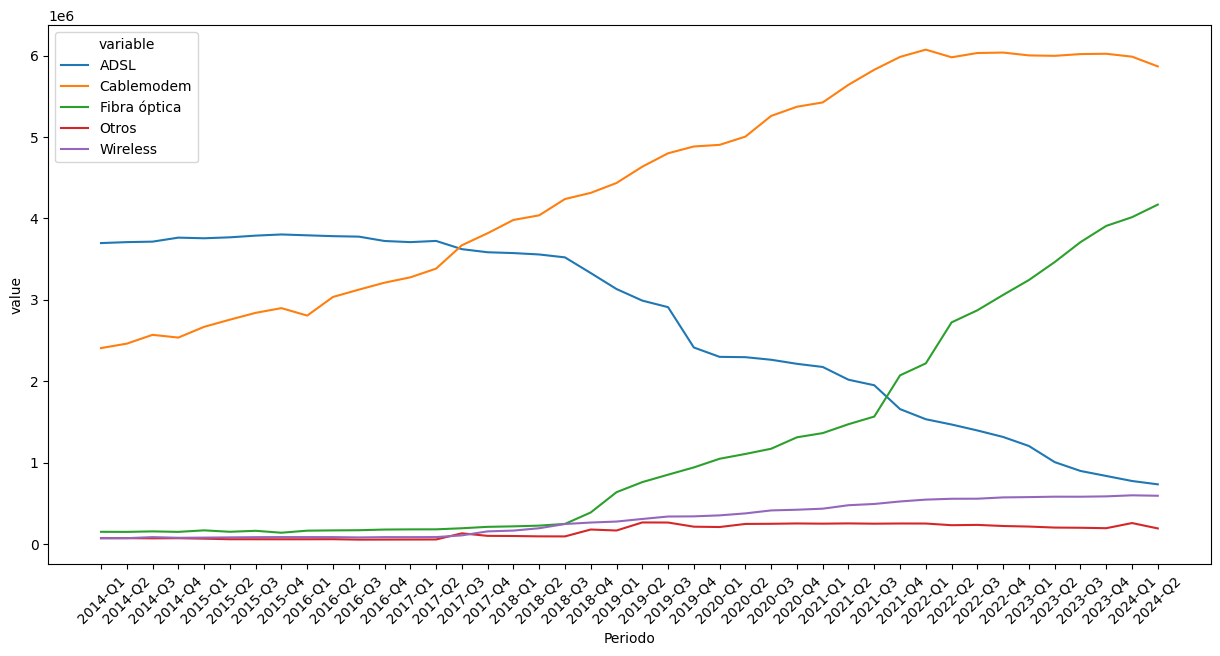

In [319]:
plt.figure(figsize=(15, 7))
plt.xticks(rotation=45)
sns.lineplot(data= totales_accesos_por_tecnologia_melted, x="Periodo", y="value", hue='variable')


Observación:

- CABLEMODEM: Incremento a lo largo de los últimos años con un freno a partir del año 2021.
- ADSL: Descenso constante
- Fibra Óptica: Comienza a incrementar inciando el año 2018-Q2.
- Wireless: Crecimiento constante.
- Otros: Crecimiento en el año 2017 y posterior freno.

## KPI: Tasa de crecimiento anual de tecnologia (AGRT)
Queremos evaluar la tasa de crecimiento de cada tecnologia para ver su comportamiento en cada periodo.


In [336]:
#Cambiamos los nombres para un mejor entendimiento
totales_accesos_por_tecnologia_melted.rename(columns={"variable" : "Tecnologia", "value" : "Accesos"}, inplace=True)

In [337]:
tasa_crecimiento_anual_tecnologia = totales_accesos_por_tecnologia_melted[totales_accesos_por_tecnologia_melted["Trimestre"]==2]

In [338]:
#Ordenamos valores
tasa_crecimiento_anual_tecnologia = tasa_crecimiento_anual_tecnologia.sort_values(by=["Tecnologia", "Periodo"])

#Calculamos la tasa de crecimiento anual con ayuda del método pct_change
tasa_crecimiento_anual_tecnologia['Crecimiento'] = tasa_crecimiento_anual_tecnologia.groupby(by=["Tecnologia"])["Accesos"].pct_change()

In [339]:
# Ejemplo de visualización del crecimiento trimestral
tech="Cablemodem"
mask = tasa_crecimiento_anual_tecnologia["Tecnologia"]==tech
tasa_crecimiento_anual_tecnologia[mask]

,Año,Trimestre,Periodo,Total,Tecnologia,Accesos,Crecimiento
43,2014,2,2014-Q2,6464468,Cablemodem,2461670,NaN
47,2015,2,2015-Q2,6816188,Cablemodem,2756294,0.119685
51,2016,2,2016-Q2,7130079,Cablemodem,3035272,0.101215
55,2017,2,2017-Q2,7429664,Cablemodem,3383434,0.114705
59,2018,2,2018-Q2,8110444,Cablemodem,4038141,0.193504
63,2019,2,2019-Q2,8960181,Cablemodem,4635575,0.147948
67,2020,2,2020-Q2,9031056,Cablemodem,5005115,0.079718
71,2021,2,2021-Q2,9863084,Cablemodem,5641731,0.127193
75,2022,2,2022-Q2,10958684,Cablemodem,5979214,0.059819
79,2023,2,2023-Q2,11251897,Cablemodem,5997149,0.003000


In [343]:
# Cambios a formato WIDE, para anexar el BW-medio y evaluar
crecimiento_por_tecnologia = tasa_crecimiento_anual_tecnologia.pivot(columns=["Tecnologia"], values="Crecimiento", index="Año").reset_index()
crecimiento_por_tecnologia

Tecnologia,Año,ADSL,Cablemodem,Fibra óptica,Otros,Wireless
0,2014,NaN,NaN,NaN,NaN,NaN
1,2015,0.015891,0.119685,0.009882,-0.180060,0.133582
2,2016,0.003786,0.101215,0.112365,0.005494,0.041120
3,2017,-0.015485,0.114705,0.077413,-0.056488,0.004225
4,2018,-0.044663,0.193504,0.251736,0.684455,1.263841
5,2019,-0.159327,0.147948,2.362105,1.806664,0.585586
6,2020,-0.232381,0.079718,0.454697,-0.069016,0.222838
7,2021,-0.120646,0.127193,0.330273,0.026460,0.266286
8,2022,-0.272594,0.059819,0.849749,-0.086542,0.166206
9,2023,-0.314523,0.003000,0.271989,-0.125993,0.045987


Conclusiones:
Se observa que en los últimos años, las unicas tecnologias que han crecido son Fibra Óptica y Wireless

# Accesos Por Tecnología
Representa la evolución por region de las tecnologias

In [352]:
accesos_por_tecnologia = file["Accesos Por Tecnología"].copy()
accesos_por_tecnologia

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
0,2024,2,Buenos Aires,214055.0,2722466.0,1849476.0,138638.0,64745.0,4989380.0
1,2024,2,Capital Federal,54102.0,1144781.0,230402.0,4493.0,29821.0,1463599.0
2,2024,2,Catamarca,4951.0,10303.0,58355.0,1384.0,81.0,75074.0
3,2024,2,Chaco,9448.0,57935.0,68944.0,8407.0,2358.0,147092.0
4,2024,2,Chubut,25955.0,80704.0,26516.0,31118.0,9930.0,174223.0
...,...,...,...,...,...,...,...,...,...
1004,2014,1,Santiago Del Estero,32567.0,3598.0,19.0,915.0,34.0,37133.0
1005,2014,1,Tierra Del Fuego,21618.0,2837.0,648.0,1.0,2934.0,28038.0
1006,2014,1,Tucumán,129717.0,83.0,121.0,13.0,98.0,130032.0
1007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [353]:
# Observación:
accesos_por_tecnologia.loc[1008]['Trimestre']

'Los datos provinciales no coinciden a nivel nacional, ya que se rincorporó información que no contien apertuta a nivel geográfico.'

In [354]:
# Aqui observamos que no hay valores para Buenos Aires para el periodo 2024 - trimestre 1. 
mask = (accesos_por_tecnologia["Año"]==2024) & (accesos_por_tecnologia["Trimestre"]==1) & (accesos_por_tecnologia["Provincia"]=="Buenos Aires")
accesos_por_tecnologia[mask]

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total


In [355]:
# Optamos por rellenar con el dato mas cercano. 2023 q4
accesos_por_tecnologia.loc[1009] = accesos_por_tecnologia.loc[47]
accesos_por_tecnologia.loc[1009, "Año"] = 2024
accesos_por_tecnologia.loc[1009, "Trimestre"] = 1

In [356]:
# verificamos:
accesos_por_tecnologia.tail()

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
1005,2014,1,Tierra Del Fuego,21618.0,2837.0,648.0,1.0,2934.0,28038.0
1006,2014,1,Tucumán,129717.0,83.0,121.0,13.0,98.0,130032.0
1007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008,*,Los datos provinciales no coinciden a nivel na...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009,2024,1,Buenos Aires,223391.0,2797700.0,1784593.0,137993.0,67943.0,5011620.0


In [357]:
# Dropeamos NA
accesos_por_tecnologia.dropna(inplace=True)

#Normalizamos valores de provincias
#Primero aplicamos caps a todos los valores
accesos_por_tecnologia["Provincia"] = accesos_por_tecnologia["Provincia"].apply(str.upper)

#Removemos los acentos.
replace_dict = {"Á" : "A", "É" : "E", "Í" : "I", "Ó" : "O", "Ú": "U"}
for key, value in replace_dict.items():
    accesos_por_tecnologia["Provincia"] = accesos_por_tecnologia["Provincia"].apply(str.replace, args=(key, value))

# Ultimamente observamos que CABA y CAPITAL FEDERAL representan la misma provincia
accesos_por_tecnologia["Provincia"] = accesos_por_tecnologia["Provincia"].apply(str.replace, args=("CAPITAL FEDERAL", "CABA"))


In [358]:
# Agregamos la columna periodo.
accesos_por_tecnologia["Periodo"] = accesos_por_tecnologia["Año"].astype(str) + "-Q" + accesos_por_tecnologia["Trimestre"].astype(str)


A esta tabla podemos darle un tratamiento similar al dataset anterior, hayando el TCAT por REGION.

In [ ]:
# Calculamos de manera anual
accesos_por_tecnologia_anual = accesos_por_tecnologia[accesos_por_tecnologia["Trimestre"]==2]

In [ ]:
# Ordenamos la data.
accesos_por_tecnologia_anual = accesos_por_tecnologia_anual.sort_values(by=["Provincia", "Periodo"]).reset_index(drop=True)

In [371]:
accesos_por_tecnologia_anual

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total,Periodo
0,2014,2,BUENOS AIRES,1568881.0,1025490.0,120008.0,17020.0,33147.0,2764546.0,2014-Q2
1,2015,2,BUENOS AIRES,1581770.0,1141052.0,115660.0,19268.0,26040.0,2883790.0,2015-Q2
2,2016,2,BUENOS AIRES,1579448.0,1305949.0,113070.0,21163.0,25661.0,3045291.0,2016-Q2
3,2017,2,BUENOS AIRES,1378549.0,1535037.0,119132.0,21555.0,24358.0,3078631.0,2017-Q2
4,2018,2,BUENOS AIRES,1450203.0,1807868.0,143626.0,71256.0,27746.0,3500699.0,2018-Q2
...,...,...,...,...,...,...,...,...,...,...
235,2020,2,TUCUMAN,150084.0,9833.0,55120.0,1357.0,762.0,217156.0,2020-Q2
236,2021,2,TUCUMAN,110429.0,48359.0,71683.0,1837.0,743.0,233051.0,2021-Q2
237,2022,2,TUCUMAN,85893.0,15327.0,148823.0,3997.0,487.0,254527.0,2022-Q2
238,2023,2,TUCUMAN,50019.0,20012.0,188986.0,4060.0,525.0,263602.0,2023-Q2


In [ ]:
# Calculamos el ratio de cambio anual por tecnologia por provincia.
ratio_cambios_tecnologia_anual = accesos_por_tecnologia_anual.groupby(by=["Provincia"])[["ADSL", "Cablemodem", "Fibra óptica", "Wireless", "Otros"]].pct_change()

In [376]:
# Hacemos merge y mostramos el dframe.
ratio_cambios_tecnologia_anual_por_provincia = pd.merge(accesos_por_tecnologia_anual[["Año", "Provincia"]], ratio_cambios_tecnologia_anual, left_index=True, right_index=True)
ratio_cambios_tecnologia_anual_por_provincia

,Año,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros
0,2014,BUENOS AIRES,NaN,NaN,NaN,NaN,NaN
1,2015,BUENOS AIRES,0.008215,0.112690,-0.036231,0.132080,-0.214409
2,2016,BUENOS AIRES,-0.001468,0.144513,-0.022393,0.098350,-0.014555
3,2017,BUENOS AIRES,-0.127196,0.175419,0.053613,0.018523,-0.050777
4,2018,BUENOS AIRES,0.051978,0.177736,0.205604,2.305776,0.139092
...,...,...,...,...,...,...,...
235,2020,TUCUMAN,-0.063818,0.096821,500.090909,4.384921,1.419048
236,2021,TUCUMAN,-0.264219,3.918031,0.300490,0.353721,-0.024934
237,2022,TUCUMAN,-0.222188,-0.683058,1.076127,1.175830,-0.344549
238,2023,TUCUMAN,-0.417659,0.305670,0.269871,0.015762,0.078029


In [378]:
# Observamos los últimos dos años
ratio_cambios_tecnologia_anual_por_provincia[ratio_cambios_tecnologia_anual_por_provincia["Año"] >=2023].describe()

,ADSL,Cablemodem,Fibra óptica,Wireless,Otros
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,-0.292263,0.004843,1.830530,0.073146,-0.063861
std,0.120242,0.123293,8.903559,0.314546,0.370180
min,-0.530225,-0.408520,0.041979,-0.217648,-0.979513
25%,-0.358579,-0.034412,0.181890,-0.004187,-0.101461
50%,-0.284996,-0.001988,0.302527,0.011816,-0.035098
75%,-0.224527,0.049546,0.642966,0.042296,0.000423
max,-0.028383,0.444823,61.883065,2.101913,1.779267


Nuevamente a nivel de provincias vemos que los valores de tecnologias de Fibra y Wireless son los que tienen valores positivos en los últimos dos años, indicando crecimiento anual.

# Penetracion-hogares
Evolución de la cantidad de accesos cada 100 hogares por provincia

In [6]:
penetracion_hogares = file["Penetracion-hogares"]

In [7]:
#Normalizamos valores de provincias
#Primero aplicamos caps a todos los valores
penetracion_hogares["Provincia"] = penetracion_hogares["Provincia"].apply(str.upper)

#Removemos los acentos.
replace_dict = {"Á" : "A", "É" : "E", "Í" : "I", "Ó" : "O", "Ú": "U"}
for key, value in replace_dict.items():
    penetracion_hogares["Provincia"] = penetracion_hogares["Provincia"].apply(str.replace, args=(key, value))

# Ultimamente observamos que CABA y CAPITAL FEDERAL representan la misma provincia
penetracion_hogares["Provincia"] = penetracion_hogares["Provincia"].apply(str.replace, args=("CAPITAL FEDERAL", "CABA"))

In [10]:
penetracion_hogares = penetracion_hogares.sort_values(by=["Provincia", "Año", "Trimestre"]).reset_index(drop=True)

In [12]:
mask = (penetracion_hogares["Año"]==2024) & (penetracion_hogares["Trimestre"] == 2)
penetracion_hogares[mask].sort_values(by="Accesos por cada 100 hogares")

,Año,Trimestre,Provincia,Accesos por cada 100 hogares
377,2024,2,FORMOSA,39.69
167,2024,2,CHACO,44.06
917,2024,2,SANTIAGO DEL ESTERO,49.67
753,2024,2,SAN JUAN,51.17
293,2024,2,CORRIENTES,51.38
545,2024,2,MENDOZA,52.30
712,2024,2,SALTA,55.72
587,2024,2,MISIONES,57.73
419,2024,2,JUJUY,58.30
999,2024,2,TUCUMAN,60.84


Observación:
- Existen lugares en donde la penetración hogares es muy por debajo del 50% inclusive a día de hoy. 
- El índice de penetración-hogar es un KPI de por sí. Podemos hacer uso de él para poner énfasis en las zonas con menor penetración.


# Conclusiones

- Si bien a grandes rasgos las tecnologias de CABLEMODEM y FIBRA ÓPTICA son las que se encuentran en mayor cantidad en la actualidad, existen partidos con ausencia de estos enlaces, los cuales son buenos candidatos para la adopción de otras tecnologías wireless
- El KPI: Rate de banda ancha, nos ayuda a identificar regiones en donde no se tiene oferta de enlaces de banda ancha, los cuales son potenciales puntos para la venta de nuestros productos.
- El KPI: Tasa de incremento anual de enlaces, junto con la velocidad media por region, nos ayuda a identificar zonas que no han tenido desarrollo ni inversión en infraestructura durante los últimos años. 
- Con el KPI: Ratio de adopción de tecnología, detectamos que hay Partidos que incluso poseen un 0% de adopción de fibra y verificamos que continuan usando enlaces DIAL-UP, tecnología en decadencia y deprecada. Estas zonas son críticas y presentan focos de posibles nichos de negocio.
- Con el KPI: Tasa de crecimiento anual de tecnología, detectamos que las tecnologías que se encuentran siendo implementadas en los últimos dos años son tanto la fibra como enlaces WIRELESS, a diferencia de otros enlaces que tienen crecimiento negativo, es decir, se encuentran siendo desplazadas.
- El índice de Penetración-Hogares es un KPI en sí, y nos ayuda a  detectar las regiones con menores cobertura. Estas regiones con baja cobertura también deben ser evaluados como posibles mercados de tecnología WIRELESS.

# Guardado de tablas modificadas

In [ ]:
# tabla con velocidades medias por provincia por periodo
mean_speed_df.to_csv("Data/Tablas Modificadas/mean_speed.csv")

In [883]:
# tabla con categorias asignadas a cada region
category_df.to_csv("Data/Tablas Modificadas/region_category.csv")

In [ ]:
enlaces_por_periodo_region.to_csv("Data/Tablas Modificadas/evolucion_accesos_y_velocidad.csv", index=False)

In [116]:
# Hacemos un reshape del dataset con MELT. 
accesos_por_tecnologia_melt = accesos_por_tecnologia.melt(id_vars=["Provincia", "Periodo"], value_vars=['ADSL', 'Cablemodem', 'Fibra óptica','Wireless', 'Otros'], var_name="Tecnologia").sort_values(by=["Provincia", "Periodo", "Tecnologia"])

# Guardamos
accesos_por_tecnologia_melt.to_csv("Data/Tablas Modificadas/accesos_por_tecnologia.csv", index=False)

In [ ]:
rangos_velocidad_partido.to_csv("Data/Tablas Modificadas/rangos_velocidad_partido.csv")

In [72]:
total_vmd.to_csv("Data/Tablas Modificadas/velocidad_media_total.csv")

In [81]:
totales_accesos_por_tecnologia_melted.to_csv("Data/Tablas Modificadas/totales_accesos_por_tecnologia.csv")

In [180]:
rangos_velocidad_partido_melted.to_csv("Data/Tablas Modificadas/rate_banda_ancha.csv")

In [265]:
variacion_anual_media_enlaces.to_csv("Data/Tablas Modificadas/variación_anual_enlaces.csv")

In [302]:
ratio_accesos_tecnologia.to_csv("Data/Tablas Modificadas/ratio_aceptacion_tecnologia_partido.csv")

In [344]:
crecimiento_por_tecnologia.to_csv("Data/Tablas Modificadas/crecimiento_anual_por_tecnologia.csv")